# WORD VECTORS

The first and arguably the most important common denominator across all NLP tasks is how to represent words as input to any model. We also need to have some notion of similarity and difference between words.

Word vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, machine translation, etc. It is important to build some intuition as to their strengths and weaknesses.

We want to encode word tokens each into some vector that represents a point in some sort of "word" space. Ideally, each dimension would encode some meaning that we transfer using speech. With word vectors, we can quite easily compute similarity of words using different measures such as Jaccard coefficient, Cosine similarity or Euclidean distance.

There are different methods to find word embeddings (word vectors). The most simple word vector is the <b>one-hot vector</b>. It represents every word as an $ \mathbb{R}^{|V| x 1} $ vector with all 0s and one 1 at the index if that word in the dictionary:

$$ V['cat'] = 2 \implies w^{cat} = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix} $$

However, this representation does not give us directly any notion of similarity. All the word vectors are pairwise orthogonal. Using cosine similarity as an example, we would get:

![Motel Hotel](img/word2vec_motel_hotel.png "Motel Hotel")


The idea is to try to reduce the size of this vector space from $ \mathbb{R}^{|V|} $ to something smaller and thus find a subspace that enocdes the relationship between words. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space.

Many word vector implementations are driven by the idea that similar words (or even synonyms) will be used in similar contexts and, by examining these contexts, we can try to develop embeddings for our words. This idea is based on the famous quotation by John Rupert Firth <i>"You shall know a word by the company it keeps."</i>

![Word Context](img/word2vec_context.png "Word Context")

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("../")

import collections
import itertools

from src.word2vec import word2vec
from src.solver import UnsupervisedSolver
from src.layers import sigmoid, word_embedding_forward, negative_sampling_loss
from src.utils.gradient_check import eval_numerical_gradient, rel_error

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# plot configuration
%matplotlib inline
plt.rcParams["figure.figsize"] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Count-based Methods

Many "old school" approaches to constructing word vectors relied on word counts. We loop over a massive dataset and accumulate word co-occurrence counts in some form of a matrix $ X $.

### Word-Document Matrix

We could make the conjecture that words that are related will often appear in the same documents and we use this fact to build a word-document matrix $ X $ in the following manner: loop over billions of documents and for each time a word <i>i</i> appears in document <i>j</i>, we add one to the entry $ X_{ij} $.

Document 1: "all that glitters is not gold"  
Document 2: "all is well that ends well"  

|     *    | doc1 | doc2 |
|----------|------|------|
| all      |  1   |  1   |
| that     |  1   |  1   |
| glitters |  1   |  0   |
| is       |  1   |  1   |
| not      |  1   |  0   |
| gold     |  1   |  0   |
| well     |  0   |  2   |
| ends     |  0   |  1   |

Now, the rows of our matrix could be the vector embeddings of our words. However, the problem with this matrix is that it scales with the number of documents.

### Window Co-occurrence Matrix

Another approach we could try is to count the number of times each word appears inside a window of a particular size around the word of interest. Given a word in a document $ w_{i} $, we consider <i>the context window</i> of size $ n $ surrounding $ w_{i} $, i.e. the $ n $ preceeding and $ n $ subsequent words in that document ( $ w_{i-n}, ..., w_{i-1} $ and $ w_{i+1}, ..., w_{i+n} $ ).We build a co-occurrence matrix $ M $ in which $ M_{ij} $ is the number of times $ w_{j} $ occurs inside $ w_{i} $ 's window. To build the matrix we calculate this count for all the words and all the documents.

Document 1: "all that glitters is not gold"  
Document 2: "all is well that ends well"  


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

<b>Note</b>: It is often the practice to add  `<START>` and `<END` tokens to represent the beginning and end of sentences, paragraphs or documents.

Again, the rows of our matrix could be the vector embeddings of our words, however, the size of the vector space is still $ \mathbb{R}^{|V|} $. To address this problem we can perform <i>dimensionality reduction</i> using <i>Singular Value Decomposition</i>. We decompose $ M = U \Sigma V^{T} $ and select the top $ k $ principle components by truncating the matrix $ U $.

In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform the decomposition. However, if you only want the top $ k $ vector components for a relatively small $ k $ then there are reasonably scalable techniques to compute those iteratively.

<b>Note:</b> We could also perform SVD on the Word-Document matrix, however, the window-based assumption is much more reasonable. The Word-Document matrix could be regarded, in a sense, as a Window Co-occurrence matrix with variable window size equal to the length of the current document.


## Iteration-based Methods

Another approach is to try to create a model that will be able to learn one iteration at a time and eventually be able to encode the probability of a word given its context.

The idea is to train a simple neural network with a single hidden layer to perform a cetain task, but then we're not actually going to use that neural network for the task we trained it on. Instead, the goal is to actually just learn the weights of the hidden layer. These weights are actually the "word vectors".

A <b>language model</b> assigns probability to a sequence of tokens. A good language model will assign high probability to valid sentences and low probability to invalid sentences. Mathematically we can express this by:

$$ \displaystyle
P(w_{1}, w_{2}, ..., w_{k}) = \prod_{i=2}^{k} P(w_{i} | w_{i-1}, ..., w_{1}) $$

for a sentence with $ k $ words.

A <i>unary language model</i> assumes the word occurrences are completely independent:

$$ \displaystyle
P(w_{1}, w_{2}, ..., w_{k}) = \prod_{i=1}^{k} P(w_{i}) $$

However, this model is not very accurate because we know that the next word is highly contingent upon the previous sequence of words. So we could try using an <i>n-gram language model</i> where we assume that each word occurence depends on the previous $ n-1 $ words.

$$ \displaystyle
P(w_{1}, w_{2}, ..., w_{k}) = \prod_{i=2}^{k} P(w_{i} | w_{i-1}, ..., w_{i-(n-1)}) $$

The idea was further developed and two algorithms for learning word vectors were proposed in 2013 by Tomas Mikolov, Kai Chen, Greg Corrado and Jeff Dean in their paper:  
<i>[1] " Efficient Estimation of Word Representations in Vector Space"</i>.
 * <b>Continuous bag-of-words (CBOW)</b>, which aims to predict a center word from the surrounding context.
 * <b>Skip-gram</b>, which aims to predict the distribution (probability) of context words from a center words.

## CBOW

#### The Fake Task
The goal of the CBOW algorithm is: given context words to accurately learn to predict the center word.

For given context words $ w_{t-m}, ..., w_{t-1}, w_{t+1}, ..., w_{t+m} $ the probability of the center word is:

$$ P(w_{t} |  w_{t-m}, ..., w_{t-1}, w_{t+1}, ..., w_{t+m}) $$

The exact ordering of the words in the context is ignored, only the number of occurances of each term is material, thus the name <i>bag-of-words</i>.

Given specific context words $ w_{t-m}, ..., w_{t-1}, w_{t+1}, ..., w_{t+m} $, a question arrises how to calculate that probability $ P(w_{t} |  w_{t-m}, ..., w_{t-1}, w_{t+1}, ..., w_{t+m}) $. Assume we have <i>some</i> learned embeddings of the words (say $ u_{1}, u_{2}, ..., u_{|V|} $). For a given context around a center word $ w_{t} $, we take the average of the vectors of the context words:

$$ \displaystyle
\upsilon_{t} = \frac{u_{t-m} + ... + u_{t-1} + u_{t+1} + ... + u_{t+m}}{2m} $$

Having obtained the vector $ \upsilon_{t} $, we can use softmax classification to compute the probability for each word in the dictionary to be our center word.

$$
\begin{bmatrix} - \space \upsilon_{t} \space - \end{bmatrix}
\begin{bmatrix} | & | & \cdots & | \\ 
                \theta_{1} & \theta_{2} & \cdots & \theta_{|V|} \\
                | & | & \cdots & |
\end{bmatrix}
=
\begin{bmatrix} \upsilon_{t} \theta_{1} \\
                \upsilon_{t} \theta_{2} \\
                \vdots \\
                \upsilon_{t} \theta_{|V|}
\end{bmatrix}
\underset{softmax}{\Rightarrow}
\begin{bmatrix} 
   \displaystyle\frac{exp(\upsilon_{t} \theta_{1})}{\displaystyle \sum_{i=1}^{|V|}exp(\upsilon_{t} \theta_{i})} \\
   \displaystyle\frac{exp(\upsilon_{t} \theta_{2})}{\displaystyle \sum_{i=1}^{|V|}exp(\upsilon_{t} \theta_{i})} \\
                \vdots \\
   \displaystyle\frac{exp(\upsilon_{t} \theta_{|V|})}{\displaystyle \sum_{i=1}^{|V|}exp(\upsilon_{t} \theta_{i})}
\end{bmatrix}
$$

The weights of the softmax classifier are stored in a matrix $ W_{D x |V|} $.

We now have:

$$ \displaystyle
P(w_{t} | w_{t-m}, ..., w_{t-1}, w_{t+1}, ..., w_{t+m}) = \frac{e^{\upsilon_{t} \theta_{t}}}{\displaystyle\sum_{i=1}^{|V|}e^{\upsilon_{t} \theta_{i}}} $$

Let's say we have a vocabulary of $ |V| $ words, where each word is represented by a one-hot vector. If we store all the currently learned embeddings in a matrix $ U_{|V| x D} $ ($ D $ is the size of the embedding), then mapping a one-hot vector to its corresponding embedding can be seen as a vector-matrix multiplication. Multiplying a one-hot vector by a matrix effectively selects the matrix row whose index corresponds to the index of the 1 in the one-hot vector:

$$ u_{t} =
\underbrace
{\begin{bmatrix} 0 & 0 & \cdots & 0 & 1 & 0 & \cdots & 0 \end{bmatrix}}
_{\text{1 at position t}}
\begin{bmatrix} - \space u_{1} \space -  \\
                - \space u_{2} \space -  \\
                \vdots \\
                - \space u_{t} \space -  \\
                \vdots \\
                - \space u_{|V|} \space -
\end{bmatrix} $$

Calculating the sum of the embeddings of some words can be computed by stacking the one-hot vectors of these words one after another into a $ 1 x 2m|V| $ vector and stacking the embedding matrix in the same manner into a $ 2m|V| x D $ matrix:

$$ \upsilon_{t} =
\begin{bmatrix}
0 & \cdots & 1 & \cdots & 0 & \cdots & \cdots & 0 & \cdots & 1 & \cdots & 0
\end{bmatrix}_{1 x 2m|V|}
\begin{bmatrix} - \space u_{1} \space -  \\ 
                \vdots \\
                - \space u_{|V|} \space - \\
                - \space u_{1} \space -  \\ 
                \vdots \\
                - \space u_{|V|} \space - \\
                \vdots \\
                \vdots \\
                - \space u_{1} \space -  \\ 
                \vdots \\
                - \space u_{|V|} \space -
\end{bmatrix}_{2m|V| x D} $$

The entire process can be modelled as training a two-layer neural network. There is no activation function for the neurons in the hidden layer. The weights of the first layer are the embeddings we are trying to learn and the weights of the second layer are the weights for a softmax classifier.

![CBOW](img/word2vec_cbow.png "CBOW")

In practice, instead of multiplying one-hot vectors with the embedding matrix, we can perform simple table lookups to obtain embeddings of the contextual words and, after that, sum the vectors to arrive at the desired result.

#### The objective function

For each position in a text $ t = 1, ..., T $ we predict the center word given the context words within a window of size $ m $. Thus, the likelihood of the text is given by the product of the probabilities of the center words:

$$ \displaystyle
\underbrace{\text{Likelihood =} L(\eta)}_{\substack{\eta \space \text{is all variables} \\ \text{ to be optimized}}} = \prod_{t=1}^{T} P(w_{t} |  w_{t-m}, ..., w_{t-1}, w_{t+1}, ..., w_{t+m}; \eta) $$

The objective function (the loss) is the average negative log of the likelihood:  


$$ \displaystyle
J(\eta) = -\frac{1}{T}logL(\eta) = -\frac{1}{T}\sum_{t=1}^{T} logP(w_{t} |  w_{t-m}, ..., w_{t-1}, w_{t+1}, ..., w_{t+m}; \eta) $$  


$$ \displaystyle
J(\eta) = -\frac{1}{T} \sum_{t=1}^{T} log \frac{e^{\upsilon_{t}\theta_{t}}}{\displaystyle\sum_{i=1}^{|v|} e^{\upsilon_{t}\theta_{i}}} $$  


$$ \displaystyle
J(\eta) = \frac{1}{T} \sum_{t=1}^{T} (log \sum_{i=1}^{|V|} e^{\upsilon_{t}\theta_{i}} -  \upsilon_{t}\theta_{t}) $$  


The loss for each example is equal to the cross-entropy loss between the true distribution (the one-hot vector of the center word) and the predicted distribution.

To perform one step in the optimization process, we need to find the gradients of the loss function with repsect to the parameters of the model $ \frac{\delta J}{\delta U} $ and $ \frac{\delta J}{\delta W} $. To calculate them we will use the chain rule:  


$$ \displaystyle
\frac{\delta J}{\delta W} = \frac{\delta J}{\delta scores} \frac{\delta scores}{\delta W} $$  


$$ \displaystyle
\frac{\delta J}{\delta U} = \frac{\delta J}{\delta scores} \frac{\delta scores}{\delta W} \frac{\delta W}{\delta U} \frac{\delta U}{\delta X} = \frac{\delta J}{\delta W} \frac{\delta W}{\delta U} \frac{\delta U}{\delta X} $$  


$$ \displaystyle
\frac{\delta J}{\delta scores} =
\begin{bmatrix}
\displaystyle\frac{\delta J}{\delta s_{11}} & \displaystyle\frac{\delta J}{\delta s_{12}} & \cdots & \displaystyle\frac{\delta J}{\delta s_{1|V|}} \\
\displaystyle\frac{\delta J}{\delta s_{21}} & \displaystyle\frac{\delta J}{\delta s_{22}} & \cdots & \displaystyle\frac{\delta J}{\delta s_{2|V|}} \\
\vdots & \vdots & \ddots & \vdots \\
\displaystyle\frac{\delta J}{\delta s_{T1}} & \displaystyle\frac{\delta J}{\delta s_{T2}} & \cdots & \displaystyle\frac{\delta J}{\delta s_{T|V|}}
\end{bmatrix} $$  


$$ \displaystyle
\frac{\delta J}{\delta s_{ij}} = \frac{\delta J}{\delta \upsilon_{i}\theta_{j}}
= \frac{1}{T} \left( \frac{e^{\upsilon_{i}\theta_{j}}}{\displaystyle\sum_{k=1}^{|V|} e^{\upsilon_{i}\theta_{k}}} - \underbrace{1_{\{y(i) = j\}}}_{\text{1 if the label of i is j}} \right) $$  


We will train the model by going through each word in the text and considering it as a center word. For every center word we consider a contextual window of a fixed size (for example <i>window_size</i>=2).

![Word Context CBOW](img/word2vec_context_cbow.png "Word Context CBOW")

In [2]:
# Initialize random data.
np.random.seed(seed=0)
N = 5
T = 4
V = 10
D = 8

X = np.random.randint(low=0, high=V, size=(N, 2*T + 1))
context = np.concatenate((X[:, : T], X[:, T + 1 : ]), axis=1)
target = X[:, T].reshape(N, 1)

print("context:\n", context)
print("target:\n", target)

context:
 [[5 0 3 3 9 3 5 2]
 [4 7 6 8 1 6 7 7]
 [8 1 5 9 9 4 3 0]
 [3 5 0 2 8 1 3 3]
 [3 7 0 1 9 0 4 7]]
target:
 [[7]
 [8]
 [8]
 [3]
 [9]]


In [3]:
# Check the forward pass.
np.random.seed(seed=0)
CBOW = word2vec(vocab_size=V, embed_size=D,
                model_type="cbow", dtype=np.float64)

word_vectors, _ = word_embedding_forward(context, CBOW.params["U"])

np.set_printoptions(precision=3)
print("word vectors:\n", word_vectors)

word vectors:
 [[[-0.332 -0.449 -0.54   0.617 -0.161 -0.139 -0.396  0.246]
  [ 0.558  0.127  0.31   0.709  0.591 -0.309  0.3   -0.048]
  [ 0.718 -0.46   0.014 -0.059  0.485  0.465  0.049  0.12 ]
  [ 0.718 -0.46   0.014 -0.059  0.485  0.465  0.049  0.12 ]
  [ 0.36  -0.39   0.127 -0.217 -0.275 -0.183 -0.099  0.018]
  [ 0.718 -0.46   0.014 -0.059  0.485  0.465  0.049  0.12 ]
  [-0.332 -0.449 -0.54   0.617 -0.161 -0.139 -0.396  0.246]
  [ 0.472 -0.065  0.099 -0.27  -0.807  0.207  0.273 -0.235]]

 [[-0.281 -0.626 -0.11   0.049  0.389  0.38  -0.122 -0.096]
  [ 0.021  0.096 -0.201 -0.115 -0.213 -0.114 -0.257 -0.546]
  [-0.51  -0.067 -0.283  0.122 -0.162 -0.373 -0.009  0.135]
  [ 0.056 -0.127 -0.516  0.146 -0.287  0.016  0.231  0.041]
  [-0.033  0.13   0.046  0.46   0.241  0.038  0.14   0.106]
  [-0.51  -0.067 -0.283  0.122 -0.162 -0.373 -0.009  0.135]
  [ 0.021  0.096 -0.201 -0.115 -0.213 -0.114 -0.257 -0.546]
  [ 0.021  0.096 -0.201 -0.115 -0.213 -0.114 -0.257 -0.546]]

 [[ 0.056 -0.127 -0.5

In [4]:
# Check the backward pass.
loss, grads = CBOW.loss(X)

f = lambda W: CBOW.loss(X)[0]
for name in grads:
    grad_numeric = eval_numerical_gradient(f, CBOW.params[name], verbose=False)
    print('%s max relative error: %e' % (name, rel_error(grad_numeric, grads[name])))

W max relative error: 5.409319e-08
U max relative error: 2.545553e-07


## Skip-Gram

#### The Fake Task

The goal of the Skip-Gram algorithm is: given a "ceneter" word $ w_{t} $ (the input word) to accurately learn the probability distribution of the contextual window surrounding $ w_{t} $. The output distribution is going to relate to how likely is to find each vocabulary word nearby our input word.

For a given center word $ w_{t} $ the probability of the context words is:

$$ P(w_{t-m}, ..., w_{t-1}, w_{t+1}, ..., w_{t+m} | w_{t}) $$

A key difference with <i>CBOW</i> is that <b>we make a Naive Bayes assumtion for conditional independence</b>. In other words, given the center word, all output words are independent.

$$ \displaystyle
P(w_{t-m}, ..., w_{t-1}, w_{t+1}, ..., w_{t+m} | w_{t}) \space = \prod_{\substack{-m \leq j \leq m \\ j \neq 0}} P(w_{t+j}|w_{t}) $$

Given a specific word $ w_{k} $ we want to calculate the probability $ P(w_{k}|w_{t}) $, which is the probability that word $ w_{k} $ falls within the contextual window of $ w_{t} $. Again, assuming we have <i>some</i> learned embeddings of the words (say $ u_{1}, u_{2}, ..., u_{|V|} $), we can use softmax classification to compute that probability.

$$
\begin{bmatrix} - \space u_{t} \space - \end{bmatrix}
\begin{bmatrix} | & | & \cdots & | \\
                \theta_{1} & \theta_{2} & \cdots & \theta_{|V|} \\
                | & | & \cdots & |
\end{bmatrix}
=
\begin{bmatrix} u_{t} \theta_{1} \\
                u_{t} \theta_{2} \\
                \vdots \\
                u_{t} \theta_{|V|}
\end{bmatrix}
\underset{softmax}{\Rightarrow}
\begin{bmatrix} 
   \displaystyle\frac{exp(u_{t} \theta_{1})}{\displaystyle \sum_{i=1}^{|V|}exp(u_{t} \theta_{i})} \\
   \displaystyle\frac{exp(u_{t} \theta_{2})}{\displaystyle \sum_{i=1}^{|V|}exp(u_{t} \theta_{i})} \\
                \vdots \\
   \displaystyle\frac{exp(u_{t} \theta_{|V|})}{\displaystyle \sum_{i=1}^{|V|}exp(u_{t} \theta_{i})}
\end{bmatrix}
$$

We now have:

$$ \displaystyle
P(w_{k}|w_{t}) = \frac{e^{u_{t} \theta_{k}}}{\displaystyle \sum_{i=1}^{|V|}e^{u_{t} \theta_{i}}} $$  

Again, If we store all the currently learned embeddings in a matrix $ U_{|V| x D} $, the entire process can be modelled as training a two-layer neural network, and again, instead of multiplying a one-hot vector with the embedding matrix, we perform a simple table lookup to obtain the desired result.

![Skip-Gram](img/word2vec_skip-gram.png "Skip-Gram")


#### The objective function

For each position in the text $ t = 1, ..., T $ we predict the context words within a window of size $ m $. Thus, the likelihood of the text is given by the product of the probabilities of the context words for every center word:

$$ \displaystyle
\underbrace{\text{Likelihood =} L(\eta)}_{\substack{\eta \space \text{is all variables} \\ \text{ to be optimized}}} = \prod_{t=1}^{T} \prod_{\substack{-m \leq j \leq m \\ j \neq 0}} P(w_{t+j}\space|w_{t}; \eta) $$  

The objective function (the loss) is the average negative log of the likelihood:


$$ \displaystyle
J(\eta) = -\frac{1}{T}logL(\eta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}} logP(w_{t+j}|w_{t}; \eta) $$  


$$ \displaystyle
J(\eta) = -\frac{1}{T} \sum_{t=1}^{T} \sum_{\substack{-m \leq k \leq m \\ k \neq 0}} log \frac{e^{u_{t}\theta_{t + k}}}{\displaystyle\sum_{l=1}^{|V|} e^{u_{t}\theta_{l}}} $$  


$$ \displaystyle
J(\eta) = \frac{1}{T} \sum_{t=1}^{T} \left( 2m \space log \sum_{l=1}^{|V|} e^{u_{t}\theta_{l}} \space \space - \sum_{\substack{-m \leq k \leq m \\ k \neq 0}} u_{t}\theta_{t + k} \right) $$  

The loss for each example is equal to the sum over the contextual words of the cross-entropy loss between the true distribution of a contextual word (the one-hot vector of the contextual word) and the predicted distribution.

To calculate the gradients of the loss function with repsect to the parameters of the model $ \displaystyle \frac{\delta J}{\delta U} $ and $ \displaystyle \frac{\delta J}{\delta W} $ we will use the chain rule:  


$$ \displaystyle
\frac{\delta J}{\delta W} = \frac{\delta J}{\delta scores} \frac{\delta scores}{\delta W} $$  


$$ \displaystyle
\frac{\delta J}{\delta U} = \frac{\delta J}{\delta scores} \frac{\delta scores}{\delta W} \frac{\delta W}{\delta U} \frac{\delta U}{\delta X} = \frac{\delta J}{\delta W} \frac{\delta W}{\delta U} \frac{\delta U}{\delta X} $$  


$$ \displaystyle
\frac{\delta J}{\delta scores} =
\begin{bmatrix}
\displaystyle\frac{\delta J}{\delta s_{11}} & \displaystyle\frac{\delta J}{\delta s_{12}} & \cdots & \displaystyle\frac{\delta J}{\delta s_{1|V|}} \\
\displaystyle\frac{\delta J}{\delta s_{21}} & \displaystyle\frac{\delta J}{\delta s_{22}} & \cdots & \displaystyle\frac{\delta J}{\delta s_{2|V|}} \\
\vdots & \vdots & \ddots & \vdots \\
\displaystyle\frac{\delta J}{\delta s_{T1}} & \displaystyle\frac{\delta J}{\delta s_{T2}} & \cdots & \displaystyle\frac{\delta J}{\delta s_{T|V|}}
\end{bmatrix} $$  


$$ \displaystyle
\frac{\delta J}{\delta s_{ij}} = \frac{\delta J}{\delta u_{i}\theta_{j}}
= -\frac{2m}{T} \left( \frac{e^{u_{i}\theta_{j}}}{\displaystyle \sum_{l=1}^{|V|} e^{u_{i}\theta_{l}}} - \underbrace{1_{\{y(i) = j\}}}_{\text{1 if the label of i is j}} \right) $$  



#### Training the model

We will train the model by going through each word in the text and considering it as a center word. For every center word we consider a contextual window of a fixed size (for example <i>window_size=2</i>).

![Word context Skip-Gram](img/word2vec_context_skip-gram.png "Word Context Skip-Gram")

In [5]:
# Check the forward pass.
np.random.seed(seed=0)
SkipGram = word2vec(vocab_size=V, embed_size=D,
                    model_type="skipgram", dtype=np.float64)

word_vectors, _ = word_embedding_forward(target, SkipGram.params["U"])

np.set_printoptions(precision=3)
print("word vectors:\n", word_vectors)

word vectors:
 [[[ 0.021  0.096 -0.201 -0.115 -0.213 -0.114 -0.257 -0.546]]

 [[ 0.056 -0.127 -0.516  0.146 -0.287  0.016  0.231  0.041]]

 [[ 0.056 -0.127 -0.516  0.146 -0.287  0.016  0.231  0.041]]

 [[ 0.718 -0.46   0.014 -0.059  0.485  0.465  0.049  0.12 ]]

 [[ 0.36  -0.39   0.127 -0.217 -0.275 -0.183 -0.099  0.018]]]


In [6]:
# Check the backward pass.
loss, grads = SkipGram.loss(X)

f = lambda W: SkipGram.loss(X)[0]
for name in grads:
    grad_numeric = eval_numerical_gradient(f, SkipGram.params[name], verbose=False)
    print('%s max relative error: %e' % (name, rel_error(grad_numeric, grads[name])))

W max relative error: 2.184301e-08
U max relative error: 3.042708e-09


### NOTES

<b>NOTE 1:</b> Obviously, with no non-linearity in the hidden layer the two matrix multiplications can be collapsed into a single matrix, and the entire neural network transforms into a linear classifier. However, as stated earlier, the goal is not to train a classifier, but to learn the weights of the hidden layer.

<b>NOTE 2:</b> It is common to see the weights of the softmax classifier also reffered to as word embeddings. For CBOW $ u_{t} $ is the embedding of $ w_{t} $ when it is a center word, and $ \theta_{t} $ is the embedding of $ w_{t} $ when it is a context word. And vice-versa for Skip-Gram. It is also common to use both vectors to arrive at the final embedding for the word $ w_{t} $ (via concatenation or averaging).

<b>NOTE 3:</b> The neural network does not know anything about the offset of the output word relative to the input word. More distant words are usually less related to the current word than those close to it. To address this problem, the authors of the paper propose to give less weight to the distant words by sampling less from those words in our training examples. That is, the parameter $ m $ denotes the <i>maximal window size</i>. For each center word we select uniformly a number $ R $ in the range $ [1, m] $ and use $ R $ as the window size for this center word. This technique is referred to as <i>dynamic window size</i>.




It deos not learn a different set of probabilities for the word before the input versus the word after. 

## Training word vectors

We will train word vectors using the Skip-Gram model on Wikipedia articles.  

The dataset examined in this notebook can be downloaded from here:  
http://mattmahoney.net/dc/text8.zip

As stated earlier, we are interested in the model's parameters, not in its classification capabilities. However, if two different words appear in similar "contexts", then our model needs to output very similar results for these two words. And one way for the network to output similar results is if the word vectors for the context words are similar. Thus, our network is motivated to learn similar word vectors for similar words.  
We will learn word vector representations for the most common words in the text and will replace rare words with `UNK` token. Vocabulary size greatly impacts the computation time needed for the model to learn the vector representations. Thus, we will constrain ourselves with a relatively small vocabulary.  
The model uses L2 regularization of the weight matrices.  
Parameter update is performed using Adam update rule.

In [7]:
# Load the data.
text8_dir = "../datasets/text/"
with open(text8_dir + "text8", "r") as file:
    text = file.read()
    text = text.split()

text = text[:1000000]

print("Number of words in the dataset: ", len(text))
print("\nExample words: ", text[150:165])

Number of words in the dataset:  1000000

Example words:  ['as', 'authoritarian', 'political', 'structures', 'and', 'coercive', 'economic', 'institutions', 'anarchists', 'advocate', 'social', 'relations', 'based', 'upon', 'voluntary']


In [8]:
# Preprocess the data to create word-to-int and int-to-word mappings.
# We will index the most common words and replace rare words with "UNK" token.
# collections.Counter(list).most_common(N) returns a tuple of the N most common instances
# contained in the list along with their count number
vocab_size = 5000
count = [("UNK", 0)]
count.extend(collections.Counter(text).most_common(vocab_size - 1))
count = dict(count)
count["UNK"] = len(text) - sum(count.values())
print("Most common words:\n", dict(itertools.islice(count.items(), 25)))

word_to_idx = {w: i for i, w in enumerate(count)}
idx_to_word = {i: w for i, w in enumerate(count)}
print("Vocab:\n", dict(itertools.islice(word_to_idx.items(), 25)))   # slicing a dictionary with itertools.islice

data = [word_to_idx.get(w, word_to_idx["UNK"]) for w in text]

print("\nVocabulary size: %d" % vocab_size)
print("Example text data:\n", text[:57])
print("After preprocessing:\n", data[:57])

Most common words:
 {'UNK': 144423, 'the': 62827, 'of': 36789, 'and': 25238, 'one': 24679, 'in': 22502, 'a': 18620, 'to': 18504, 'zero': 14349, 'nine': 14056, 'is': 11094, 'two': 10968, 'as': 7737, 'eight': 7708, 'three': 7049, 'was': 6892, 'by': 6796, 'five': 6647, 's': 6606, 'that': 6541, 'for': 6447, 'four': 6338, 'six': 6239, 'seven': 5914, 'with': 5672}
Vocab:
 {'UNK': 0, 'the': 1, 'of': 2, 'and': 3, 'one': 4, 'in': 5, 'a': 6, 'to': 7, 'zero': 8, 'nine': 9, 'is': 10, 'two': 11, 'as': 12, 'eight': 13, 'three': 14, 'was': 15, 'by': 16, 'five': 17, 's': 18, 'that': 19, 'for': 20, 'four': 21, 'six': 22, 'seven': 23, 'with': 24}

Vocabulary size: 5000
Example text data:
 ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', '

In [9]:
class text_dataset(object):
    def __init__(self, data, window_size):
        """
        Inputs:
        - data: List of integers representing the preprocessed data.
          Every integer corresponds to a character.
        - window_size: Integer giving the contextual window size.
        """
        self.data = data
        self.window_size = window_size
        self.span = 2 * window_size + 1 # window - target - window

    def train_batch(self, batch_size):
        """
        Generate the next batch of examples from the data.

        Returns:
        - batch: A numpy array of integers of shape (batch_size, seq_length) giving
          a batch of training examples.
        """
        span = self.span
        batch = np.ndarray((batch_size, span), dtype=np.int)

        for idx in range(batch_size):
            cursor = np.random.randint(len(self.data)-span)
            batch[idx] = self.data[cursor : cursor + span]

        return batch

    def num_train(self):
        """
        Returns:
        - num_train: Integer, giving the number of training examples in the dataset.
        """
        return len(self.data)

In [10]:
# Initialize the dataset.
np.random.seed(seed=None)
window_size = 2
dataset = text_dataset(data, window_size)

# Initialize the model
batch_size = 128
embed_size = 128
SkipGram = word2vec(vocab_size=vocab_size, embed_size=embed_size,
                    model_type="skipgram",
                    word_to_idx=word_to_idx,
                    dtype=np.float32)

In [11]:
# Train the model.
word2vec_solver = UnsupervisedSolver(SkipGram, dataset,
                                     update_rule="adam",
                                     optim_config={"learning_rate": 1e-2},
                                     lr_decay=0.5,
                                     batch_size=batch_size,
                                     clip_norm = 5.0,
                                     num_epochs=2,
                                     print_every=3500,
                                     verbose=True)

tic = time.time()
word2vec_solver.train()
toc = time.time()
print("training took %.3f minutes" % ((toc - tic) / 60))

Number of iterations per epoch: 7812
(Iteration 1 / 15624) loss: 8.51641
(Iteration 1 / 15624); Epoch(1 / 2); loss: 8.51641
Sample:
 Nearest to friend: previously made literature profile signs serious website receives enemy features
(Iteration 3501 / 15624) loss: 5.55426
(Iteration 7001 / 15624) loss: 5.54042
(Iteration 7813 / 15624); Epoch(2 / 2); loss: 5.35299
Sample:
 Nearest to friend: daughter lady boy wife editor romantic colonel cousin replacement request
(Iteration 10501 / 15624) loss: 5.32298
(Iteration 14001 / 15624) loss: 5.47640
(Iteration 15624 / 15624); Epoch(2 / 2); loss: 5.01387
Sample:
 Nearest to friend: wife daughter hector husband son lady branden augusta sensei uncle
training took 62.710 minutes


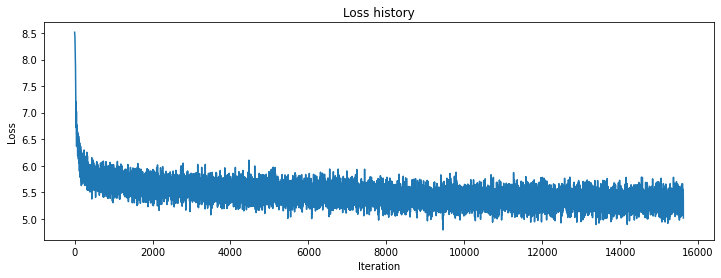

In [12]:
# Plot the loss function.
plt.plot(word2vec_solver.loss_history)
plt.title("Loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.gcf().set_size_inches(12, 4)
plt.show()

In [13]:
# Print the nearest words
common_words = np.array([word_to_idx["six"], word_to_idx["eight"], word_to_idx["three"],
                         word_to_idx["work"], word_to_idx["friends"], word_to_idx["king"]])
similar_words = SkipGram.sample(common_words, top_k=8)

for line in similar_words:
    print(line)

# for idx in range(len(common_words)):
#     word_id = common_words[idx]
#     print("\nNearest to %s: " %(idx_to_word[word_id]), end="")
#     for ids in similar_words[idx]:
#         print(idx_to_word[ids], end=" ") 

Nearest to six: eight seven four five three zero nine one
Nearest to eight: seven six five nine three four zero one
Nearest to three: four six eight five seven two one zero
Nearest to work: attitude judgment appearance incident effort albums symbolic everyone
Nearest to friends: wife mother fellow uncle absalom lover kurtz lectures
Nearest to king: macedon constantine duke queen prince khan pope henry


In [14]:
U = SkipGram.params["U"]
norm_U = U / np.linalg.norm(U, axis=1, keepdims=True)

king = norm_U[word_to_idx["king"]]
man = norm_U[word_to_idx["man"]]
woman = norm_U[word_to_idx["woman"]]

top_k = 8
vect = king - man + woman
args = np.argsort(norm_U.dot(vect))[::-1]
nearest = args[1:top_k + 1]

print("Nearest to 'king' - 'man' + 'woman': ", end="")
for ids in nearest:
    print(idx_to_word[ids], end=" ")

Nearest to 'king' - 'man' + 'woman': woman emperor pope macedon prussia duke constantine prince 

### Efficiency

It should be noted that calculating the objective function is computationally huge. Any evaluation of the objective function would take $ O(|V|) $ time due to the summation over the entire vocabulary.

In [15]:
# Generate batch.
tic = time.time()
for i in range(10):
    batch = dataset.train_batch(batch_size)
toc = time.time()
print("Batch generation takes %.5f seconds" % (toc - tic))

# Compute the loss and gradients.
tic = time.time()
for i in range(10):
    loss, grads = word2vec_solver.model.loss(batch)
toc = time.time()
print("Loss and grads computation takes %.5f seconds" % (toc - tic))

# Update the parameters.
tic = time.time()
for i in range(10):
    for p, w in word2vec_solver.model.params.items():
        dw = grads[p]
        config = word2vec_solver.optim_configs[p]
        next_w, next_config = word2vec_solver.update_rule(w, dw, config)
toc = time.time()
print("Parameter update takes %.5f seconds" % (toc - tic))

Batch generation takes 0.04376 seconds
Loss and grads computation takes 1.97393 seconds
Parameter update takes 0.31644 seconds


In [16]:
N, span = batch.shape
window_size = (span - 1) // 2

window = np.concatenate((batch[:, : window_size], batch[:, window_size + 1 : ]), axis=1)
target = batch[:, window_size].reshape(N, 1)

N, T = window.shape
labels = window.reshape(N * T)

scores, caches = SkipGram._forward(target)
scores = scores[:, np.newaxis, :]
scores = np.tile(scores, (1, T, 1))
scores = scores.reshape(N * T, -1)
N, C = scores.shape

shifted_scores = scores - np.max(scores, axis=1, keepdims=True)

# Compute the exponents.
tic = time.time()
for i in range(10):
    exp_scores = np.exp(shifted_scores)
toc = time.time()
print("Computing the exp scores takes %.5f seconds" % (toc - tic))

# Computhe the loss
tic = time.time()
for i in range(10):
    Y = np.log(np.sum(exp_scores, axis=1, keepdims=True))
    Z = shifted_scores - Y
    loss = - np.sum(Z[np.arange(N), labels]) / N
toc = time.time()
print("Computing the loss takes %.5f seconds" % (toc - tic))

# Compute the grads
tic = time.time()
for i in range(10):
    dscores = np.exp(Z)
toc = time.time()
print("Computing the gradients step 1 takes %.5f seconds" % (toc - tic))

# Compute the grads
tic = time.time()
for i in range(10):
    dscores[np.arange(N), labels] -= 1
    dscores /= N
toc = time.time()
print("Computing the gradients step 2 takes %.5f seconds" % (toc - tic))

Computing the exp scores takes 0.54444 seconds
Computing the loss takes 0.06351 seconds
Computing the gradients step 1 takes 0.48219 seconds
Computing the gradients step 2 takes 0.02414 seconds


## Negative Sampling

In 2014 Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado and Jeff Dean address the problem of effiiency in their paper:  
<i>[2] "Distributed Representations of Word Phrases and their Compositionality"</i>.

The proposed Negative-Sampling method is described in detail by Yoav Goldberg and Omer Levy in ther paper:  
<i>[3] "word2vec Explained: Deriving Mikolov et. al.'s Negative-Sampling Word-Embedding Method"</i>.

In the previous setting we considered the conditional probability $ P(w_{t} | w_{t-j}, ..., w_{t-1}, w_{t+1}, ..., w_{t+j}) = P(w|c) $ of a word given its context (or similarly $ P(c, w) $) from a given corpus of text, and the goal was to maximize to corpus probability:

$$ \displaystyle
L(\eta) = \prod_{t=1}^{T} P(w | c; \eta) \space - \space \text{for the CBOW algorithm} $$  

$$ \displaystyle
L(\eta) = \displaystyle \prod_{t=1}^{T} P(c | w; \eta) \space - \space \text{for the Skip-Gram algorithm} $$

To do this we model the conditional probability $ P(w | c; \eta) $ using softmax:

$$ \displaystyle
P(w | c; \eta) = \frac{e^{{u_{c}\theta_{w}}}}{\displaystyle\sum_{v \in V}e^{{u_{c}\theta_{v}}}} $$

However, computing this objective is very expensive due to the summation over the entire vocabulary. A more efficient way of deriving word embeddings would be to consider a different objective. Consider a pair $ (w, c) $ of word and context and denote by $ P(D = 1| w, c) $ the probability that this pair comes from the corpus data. We can model that probability using a sigmoid function:

$$ \displaystyle
P(D = 1|w,c; \eta) = \frac{1}{1 + e^{ - u_{c} \theta_{w}}} $$

In order for the model to learn we have to present some $ (w,c) $ pairs which are not in the data. Now, the new objective function tries to maximize the probability of a pair being in the corpus data if it inedeed is, and maximize the probability of a pair not being in the corpus data if it indeed is not.  


$$ \displaystyle
L(\eta) = \prod_{(w,c) \in D} P (D = 1|w,c;\eta) \prod_{(w, c) \notin D} (1 - P(D = 1|w,c;\eta)) $$  


$$ \displaystyle
J(\eta) = - log L(\eta) = - \left( \sum_{(w,c) \in D} log \frac{1}{1 + e^{ - u_{c} \theta_{w}}} + \sum_{(w,c) \notin D} log \left( 1 - \frac{1}{1 + e^{ - u_{c} \theta_{w}}} \right) \right) $$  


$$ \displaystyle
J(\eta) = - \left( \sum_{(w,c) \in D} log \frac{1}{1 + e^{ - u_{c} \theta_{w}}} + \sum_{(w,c) \notin D} log \frac{1}{1 + e^{u_{c} \theta_{w}}} \right) $$  


For CBOW, our new objective function for observing the center word $ w_{t} $ given the context vector $ \displaystyle \hat{v} = \frac{w_{t-j} + \cdots + w_{t-1} + w_{t+1} + \cdots + w_{t+j}}{2j} $ would be:  


$$ \displaystyle
J_{CBOW}(\eta) = - log \frac{1}{1 + e^{-\theta_{t} \hat{v}}} -  \sum_{k=1}^{K} log \frac{1}{1 + e^{\theta_{k} \hat{v}}} $$  


Thus, the negative examples consist of our input context words and "untrue" center words.

For Skip-Gram, our new objective function for observing the context words $ w_{t-j}, ..., w_{t-1}, w_{t+1}, ..., w_{t+j} $ given the center word $ w_{t} $ would be:  


$$ \displaystyle
J_{SkipGram}(\eta) = - \sum_{\substack{-m \leq j \leq m \\ j \neq 0}} log \frac{1}{1 + e^{-w_{t} \theta_{t+m}}} - \sum_{k=1}^{K} log \frac{1}{1 + e^{w_{t} \theta_{k}}} $$

Thus, the negative examples consist of our input center word and "untrue" context words.

The words $ \{w_{k}\}_{k=1}^{K} $ are sampled from a noise distribution. The authors of [2] propose sampling from a uniform distribution raised to the power of $ 3/4 $. The authors also propose working with values of $ K = 5...20 $.


#### NOTE:

For computing the second term of the objective functions, we could choose both the center word $ w_{t} $ and the context words $ w_{t-j}, ..., w_{t-1}, w_{t+1}, ..., w_{t+j} $ of the negative examples from our noisy distribution.  
However, keeping the input and randomly sampling only the "untrue" output has an appealing intuitive property. Firstly, for a given input we will only update the weights of the softmax classifier for the "true" output and for the randomly chosen "untrue" outputs. And secondly, for a given input we will only update the weights of the embeddings of that input by showing the model the "true" output and the randomly choosen "untrue" outputs.

In [17]:
np.random.seed(seed=0)
N = 5
V = 8
K = 3
T = 2

s = np.array([np.arange(V) * 0.01] * N) * np.arange(1, N+1).reshape(N, 1)
s = s[:, np.newaxis, :]
s = np.tile(s, (1, T, 1))
s = s.reshape(N*T, -1)

y = np.random.randint(V, size=(N, T))
z = np.random.randint(V, size=(N, K))

In [22]:
# Check the forward pass.
loss = 0
for _n in range(N):
    for _t in range(T):
        loss -= np.log(sigmoid(s[_n, y[_n, _t]]))
    for _k in range(K):
        loss -= np.log(sigmoid(-s[_n, z[_n, _k]]))

print("Loss = %.5f" % loss)

loss, _ = negative_sampling_loss(s, y, z)
print("Loss = %.5f" % loss)

Loss = 17.56620
Loss = 17.56620


In [23]:
# Check the backward pass.
loss, ds = negative_sampling_loss(s, y, z)

f = lambda x: negative_sampling_loss(x, y, z)[0]
ds_num = eval_numerical_gradient(f, s, verbose=False)
print("max relative error: %e" % (rel_error(ds, ds_num)))

max relative error: 3.865674e-10


In [24]:
# Compare the efficiency.
np.random.seed(seed=0)
model = word2vec(vocab_size=vocab_size, embed_size=embed_size,
                 model_type="skipgram",
                 word_to_idx=word_to_idx,
                 dtype=np.float32)

tic = time.time()
for i in range(10):
    loss, grads = model.loss(batch)
toc = time.time()
print("Loss and grads computation takes %.5f seconds." % (toc - tic))


model = word2vec(vocab_size=vocab_size, embed_size=embed_size,
                 model_type="skipgram",
                 negative_sampling=10,
                 word_to_idx=word_to_idx,
                 dtype=np.float32)

tic = time.time()
for i in range(10):
    loss, grads = model.loss(batch)
toc = time.time()
print("Loss and grads computation takes %.5f seconds with negative sampling." % (toc - tic))

Loss and grads computation takes 2.14998 seconds.
Loss and grads computation takes 0.76807 seconds with negative sampling.


## Training word vectors using Negative Sampling

Again, we will train word vectors using the Skip-Gram model on Wikipedia articles. However, this time we will use the negative sampling loss to evaluate our model.    
Again, we will learn word vector representations for the most common words in the text and will replace rare words with `UNK` token.  
The model uses L2 regularization of the weight matrices.  
Parameter update is performed using Adam update rule.

In [25]:
# Initialize the model using negative sampling.
np.random.seed(seed=None)
batch_size = 128
embed_size = 128
num_negative_samples = 20

SkipGram = word2vec(vocab_size=vocab_size, embed_size=embed_size,
                    model_type="skipgram",
                    negative_sampling = num_negative_samples,   # use negative sampling
                    word_to_idx=word_to_idx,
                    dtype=np.float32)

In [26]:
# Train the model.
word2vec_solver = UnsupervisedSolver(SkipGram, dataset,
                                     update_rule="adam",
                                     optim_config={"learning_rate": 1e-2},
                                     lr_decay=0.5,
                                     batch_size=batch_size,
                                     clip_norm = 5.0,
                                     num_epochs=2,
                                     print_every=3500,
                                     verbose=True)

tic = time.time()
word2vec_solver.train()
toc = time.time()
print("training took %.3f minutes" % ((toc - tic) / 60))

Number of iterations per epoch: 7812
(Iteration 1 / 15624) loss: 2130.28613
(Iteration 1 / 15624); Epoch(1 / 2); loss: 2130.28613
Sample:
 Nearest to friend: reality aidan pierre department railway members singles francisco poet adding
(Iteration 3501 / 15624) loss: 766.36368
(Iteration 7001 / 15624) loss: 772.96403
(Iteration 7813 / 15624); Epoch(2 / 2); loss: 813.54270
Sample:
 Nearest to friend: lipsius hop cooperation observer honorary management circular warrior muslim turks
(Iteration 10501 / 15624) loss: 761.50716
(Iteration 14001 / 15624) loss: 712.20203
(Iteration 15624 / 15624); Epoch(2 / 2); loss: 731.53968
Sample:
 Nearest to friend: temples rocky wild eggs slowly wheat seven summary steven pale
training took 29.679 minutes


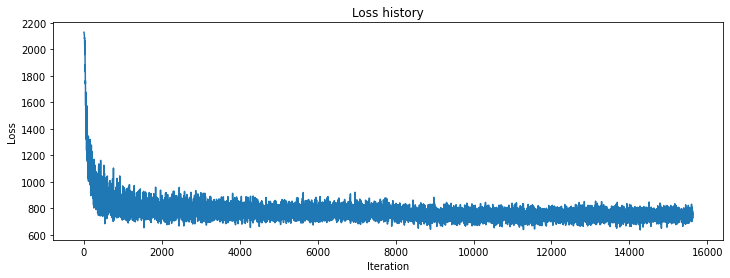

In [27]:
# Plot the loss function.
plt.plot(word2vec_solver.loss_history)
plt.title("Loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.gcf().set_size_inches(12, 4)
plt.show()

In [28]:
# Print the nearest words
common_words = np.array([word_to_idx["six"], word_to_idx["eight"], word_to_idx["three"],
                         word_to_idx["work"], word_to_idx["friends"], word_to_idx["king"]])
similar_words = SkipGram.sample(common_words, top_k=8)

for line in similar_words:
    print(line)

# for idx in range(len(common_words)):
#     word_id = common_words[idx]
#     print("\nNearest to %s: " %(idx_to_word[word_id]), end="")
#     for ids in similar_words[idx]:
#         print(idx_to_word[ids], end=" ") 

Nearest to six: UNK a one the in was eggs bulk
Nearest to eight: UNK the in was a by and is
Nearest to three: the of UNK and to in zero temples
Nearest to work: zero the nine one was and which this
Nearest to friends: planning temples amide abydos worker diagnostic allah summary
Nearest to king: temples rainfall archive circa reasoning antonio bulk dealt


In [29]:
U = SkipGram.params["U"]
norm_U = U / np.linalg.norm(U, axis=1, keepdims=True)

king = norm_U[word_to_idx["king"]]
man = norm_U[word_to_idx["man"]]
woman = norm_U[word_to_idx["woman"]]

top_k = 8
vect = king - man + woman
args = np.argsort(norm_U.dot(vect))[::-1]
nearest = args[1:top_k + 1]

print("Nearest to 'king' - 'man' + 'woman': ", end="")
for ids in nearest:
    print(idx_to_word[ids], end=" ")

Nearest to 'king' - 'man' + 'woman': king algerian sister intervention h riots j outside 